# 載入套件

In [2]:
# import pandas
import numpy as np
import jieba
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import re
# from pandarallel import pandarallel
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


import pyLDAvis
import pyLDAvis.sklearn
# import modin.pandas as pd
# import ray
# ray.init()
import gc

In [3]:
path = '/mnt/c/Users/TLYu0419/Documents/Github/DataScience/02_Data_Collenction/WebCrawler/HumanResource_104/data/'

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 讀取資料

In [3]:
# df = pd.concat([pd.read_pickle(path+'./JobDetail_20210619.pkl'),
#                 pd.read_pickle(path+'./JobDetail_20210703.pkl'),
#                 pd.read_pickle(path+'./JobDetail_20210722.pkl'),
#                 pd.read_pickle(path+'./JobDetail_20210806.pkl'),
#                 pd.read_pickle(path+'./JobDetail_20210818.pkl')],
#                ignore_index=True)
# df = df.drop_duplicates('analysisUrl')


# # Job Type
# # jobType: 1:全職, 2:兼職, 3:高階
# df = df.loc[df['jobType']==1]

# # To Annual Salary
# # salaryType: 10: 面議, 20: 論件計酬, 30: 時薪, 40: 日薪, 50: 月薪, 60: 年薪
# df = df.loc[df['salaryType'].apply(lambda x: x in [10, 50, 60])]
# df['monthly_salary'] = np.select(condlist = [df['salaryType'] == 10, # 面議
#                                             df['salaryType'] == 60, # 年薪
#                                             df['salaryType'] == 50], # 月薪
#                                 choicelist = [40000, # 面議
#                                               df['salaryMin']/13, # 年薪
#                                               df['salaryMin']]) # 月薪


# df['jobDescription'] = df['jobDescription'] + df['other']
# # Take item from list
# def take_items(item_list):
#     try:
#         return ', '.join([item['description'] for item in item_list])
#     except:
#         return ''
# df['specialty'] = df['specialty'].apply(lambda x: take_items(x))
# df['skill'] = df['skill'].apply(lambda x: take_items(x))
# df['jobCategory'] = df['jobCategory'].apply(lambda x: take_items(x))


# df = df.drop(['appearDate', 'custUrl', 'analysisUrl', 'hrName', 'email', 'visit', 'phone','acceptRole',
#               'other', 'workExp','edu', 'major', 'language','certificate','jobType', 'workType','addressNo', 
#               'addressRegion','addressDetail', 'industryArea', 'longitude', 'latitude','employees',
#               'salary', 'salaryMin', 'salaryMax', 'salaryType'], axis=1)

# df.to_pickle(path+'./JobDetail_bindall.pkl')

# 資料處理

## 程式語言職缺數量
- split job description by comma, space and take the item in progrmm list form list 

In [4]:
df = pd.read_pickle(path+'./JobDetail_bindall.pkl')
print(df.shape)

(374074, 13)


In [12]:
program_list = pd.read_html('https://www.tiobe.com/tiobe-index/')
program_list = pd.concat([program_list[0].loc[:,['Aug 2021', 'Programming Language.1','Ratings']].rename(columns={'Aug 2021':'Position',
                                                                                                        'Programming Language.1':'Languages'}),
                          program_list[1].loc[:,['Position', 'Programming Language','Ratings']].rename(columns={'Programming Language':'Languages'})],
                         ignore_index=True)

program_list['Languages'] = program_list['Languages'].apply(lambda x: x.upper())
program_list = program_list.loc[program_list['Languages']!='D']
program_list['Ratings'] = program_list['Ratings'].apply(lambda x: float(re.sub('%','',x))/100)
# program_list

In [6]:
jieba.enable_parallel(4)

jieba.add_word('C/P值')

df['program_list'] = df['specialty']+df['jobDescription']
df['program_list'] = df['program_list'].apply(lambda x: x.upper())
df['program_list'] = df['program_list'].apply(lambda x: jieba.lcut(x))
df['program_list'] = df['program_list'].apply(lambda x: list(set(x)))
df['program_list'] = df['program_list'].apply(lambda x: [prog for prog in x if prog in list(program_list['Languages'])])

jieba.disable_parallel()
df.to_pickle(path+'./JobDetail_bindall.pkl')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.583 seconds.
Prefix dict has been built successfully.


## Drop noises

In [3]:
df = pd.read_pickle(path+'./JobDetail_bindall.pkl')

In [4]:
df['program_cnt'] = df['program_list'].apply(lambda x: len(x))
df = df.loc[df['program_cnt'] >=1]

In [5]:
print(df.shape)

(30398, 15)


In [6]:
# ndf = df['jobCategory'].apply(lambda x: re.sub(' ', '', x).split(','),-1).reset_index()
# ndf.explode('jobCategory')['jobCategory'].value_counts().reset_index().head(100)['index'].values

In [7]:
condlist = [df['jobCategory'].apply(lambda x: '工程師' in x),
            df['jobCategory'].apply(lambda x: '程式設計師' in x),
            df['jobCategory'].apply(lambda x: '網頁設計師' in x),
            df['jobCategory'].apply(lambda x: '系統分析師' in x),
            df['jobCategory'].apply(lambda x: '產品管理師' in x),
            df['jobCategory'].apply(lambda x: '專案管理師' in x),
            df['jobCategory'].apply(lambda x: '營運管理師' in x),
            df['jobCategory'].apply(lambda x: '網路安全分析師' in x),
            df['jobCategory'].apply(lambda x: '研究員' in x),
            df['jobCategory'].apply(lambda x: '資訊助理人員' in x),
            df['jobCategory'].apply(lambda x: '其他資訊專業人員' in x),
            df['jobCategory'].apply(lambda x: '資料庫管理人員' in x),
            df['jobCategory'].apply(lambda x: '系統維護／操作人員' in x),
            df['jobCategory'].apply(lambda x: '統計精算人員' in x),
            df['jobCategory'].apply(lambda x: '財務分析／財務人員' in x),            
            df['jobCategory'].apply(lambda x: '軟體專案主管' in x),
            df['jobCategory'].apply(lambda x: '測試人員' in x),
            df['jobCategory'].apply(lambda x: 'MIS／網管主管' in x),
            df['jobCategory'].apply(lambda x: '資訊設備管制人員' in x),
            df['jobCategory'].apply(lambda x: '產品售後技術服務' in x),
            df['jobCategory'].apply(lambda x: '市場調查／市場分析' in x),
            df['jobCategory'].apply(lambda x: '專案管理主管' in x),
            df['jobCategory'].apply(lambda x: '電子商務技術主管' in x)]

choicelist = [True,True,True,True,True, True,True,True,True,True,
              True,True,True,True,True, True,True,True,True,True,
              True,True,True]

df = df.loc[np.select(condlist, choicelist, default=False),:]
print(df.shape)

(26255, 15)


In [18]:
df.to_pickle(path+'./JobDetail_processed.pkl')

In [451]:
df.loc[:,['jobName', 'custName', 'jobDescription', 'jobCategory', 'industry3','monthly_salary', 'program_list']].head()

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,jobName,custName,jobDescription,jobCategory,industry3,monthly_salary,program_list
5,Physical Design Methodology/CAD Manager (KW: A...,安霸股份有限公司,1.Tapeout with multi-million gates count SOC d...,"數位IC設計工程師, 硬體工程研發主管, 電子工程師",IC設計相關業,40000.0,"[PERL, C, C++]"
17,軟體工程師,泛太資訊科技開發股份有限公司,- 熟悉.NET ； 包括 ADO.Net、ASP.Net、C#.Net或VB.Net。\r...,"軟體設計工程師, Internet程式設計師, 系統分析師",電腦系統整合服務業,42000.0,"[C#, JAVASCRIPT, SQL]"
23,多媒體/網頁設計人員,魔數電腦多媒體股份有限公司,動態網頁與 UI/UX 設計\n熟dreamweaver(html5+css3)、javas...,"網頁設計師, 美術設計, 多媒體動畫設計師",多媒體相關業,25000.0,[JAVASCRIPT]
151,【顧問部】顧問師/高級顧問師 (財務風險管理 程式開發工程師)-316,KPMG_安侯建業聯合會計師事務所,1. ETL程式開發及撰寫，使用工具為SSIS、T-SQL(Store Procedure)...,"系統分析師, 資料庫管理人員, 軟體設計工程師",會計服務業,32000.0,[SQL]
152,研發替代役-軟體工程師(109年度),凌群電腦股份有限公司,軟體開發與設計、架構設計、資料設計、系統整合、軟體產品研發、技術管理、專案管理\n\n※薪資...,"軟體設計工程師, 系統分析師, Internet程式設計師",電腦系統整合服務業,37000.0,[JAVA]


# 分析1: 產業、應用與待遇
- 程式語言的職缺數量:
    - 國際與國內情況
- 程式類的職缺來自哪些產業
- 為什麼這些產業會需要這些職缺?
- 如果加上待遇的角度來看會如何?
    - MCA plot
    - 選工作盡量不要選派遣的工作

## 程式語言職缺數量

In [35]:
df = pd.read_pickle(path+'./JobDetail_processed.pkl')
print(df.shape)
df.tail(5)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(26255, 15)


,jobName,custName,specialty,skill,jobDescription,jobCategory,industry3,industryNo3,industry,industryNo,industry2,industryNo2,monthly_salary,program_list,program_cnt
1256127,供應鏈管理系統工程師(楊梅),華新科技股份有限公司,Windows 2000,,1、應用作業研究、排程最佳化等技術解決分析與優化生產製造相關實務問題，包括生產排程、產能瓶頸...,"網路管理工程師, 通訊軟體工程師, 軟體設計工程師",被動電子元件製造業,1001005002,電子資訊╱軟體╱半導體相關業,1.001000e+09,電子零組件相關業,1001005000,40000.0,[PYTHON],1
1256181,客服工程師,介宏資訊有限公司,"Windows 2000, Windows 98, MS SQL, Excel, Outlo...",,本公司為國內國際物流軟體的領導廠商，產品包括海空運報關、承攬、國際快遞、物流倉儲及運籌平台等...,"業務支援工程師, 產品售後技術服務, 其他客戶服務人員",電腦軟體服務業,1001001002,電子資訊╱軟體╱半導體相關業,1.001000e+09,軟體及網路相關業,1001001000,40000.0,[SQL],1
1256245,軟韌體研發工程師,創見資訊股份有限公司,"Linux, C, C++",,1. Embedded system 設計開發\r\n2. 硬碟儲存設備等新產品之開發\r\...,"韌體設計工程師, 軟體設計工程師",電腦及其週邊設備製造業,1001003001,電子資訊╱軟體╱半導體相關業,1.001000e+09,電腦及消費性電子製造業,1001003000,40000.0,"[C, C++]",2
1256553,系統工程師,伯諾股份有限公司,,,1. 應用系統測試\r\n2. 資訊技術通報\r\n3. 系統教育訓練\r\n4. 系統主機...,"軟體設計工程師, MIS程式設計師, 系統分析師",綜合商品批發代理業,1003001015,批發╱零售╱傳直銷業,1.003000e+09,批發業,1003001000,30000.0,[SQL],1
1257233,工業工程師 (台中廠),友達光電股份有限公司,"Excel, Outlook, PowerPoint, Project, Word, 中文打...",,1.人力規劃與效能提昇推展 \n2.自動化推展與預算審查\n3.成本費用分析\n4.預算控制...,"生管, 工業工程師／生產線規劃",光學器材製造業,1001004002,電子資訊╱軟體╱半導體相關業,1.001000e+09,光電及光學相關業,1001004000,40000.0,[SQL],1


In [36]:
ndf = df.explode('program_list')
ndf = ndf.value_counts('program_list').reset_index(name='CNT')
ndf = ndf.rename(columns={'program_list':'program'})

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0, 0.5, '')]

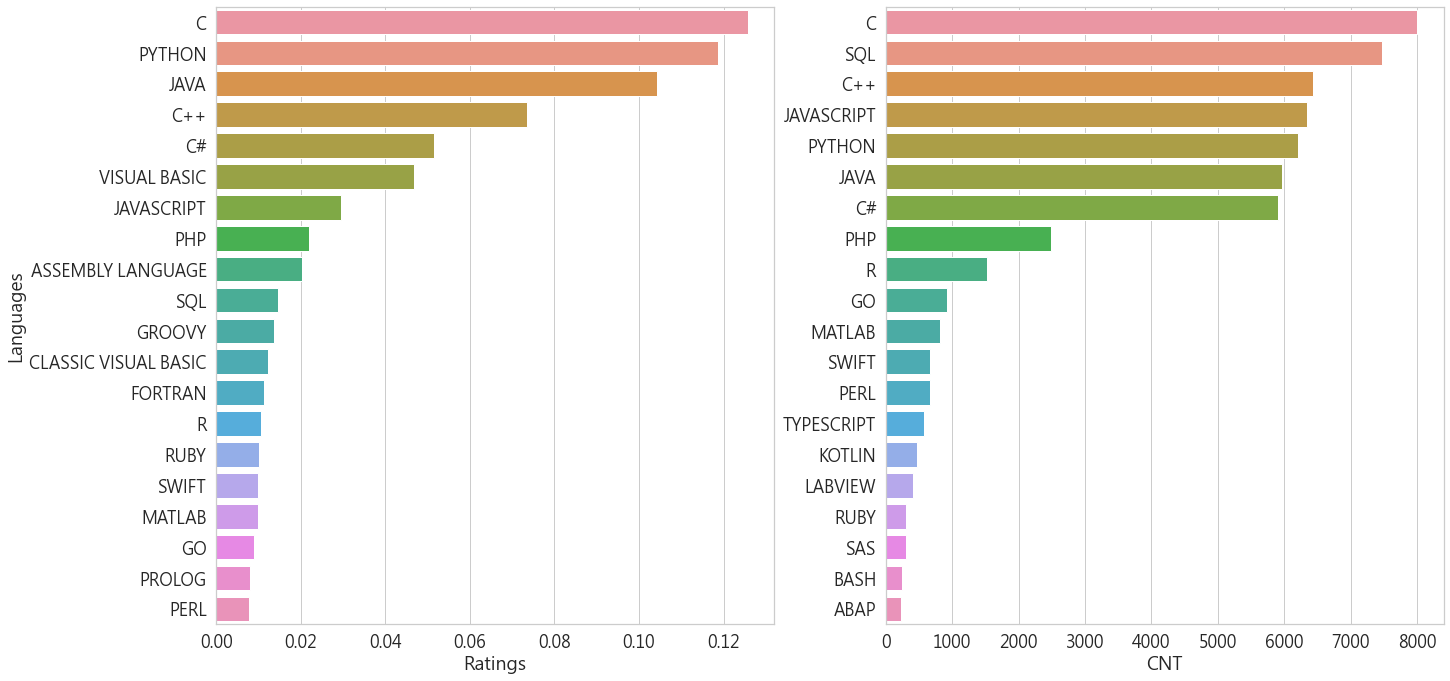

In [13]:
plt.figure(figsize=(22,25))
plt.subplot(211)
# plt.xticks(rotation=45)
sns.set_theme(style='whitegrid', font_scale=1.5)

ax1 = plt.subplot(2, 2, 1)
ax1 = sns.barplot(x='Ratings', y='Languages',data=program_list.head(20), orient='h')

ax2 = plt.subplot(2, 2, 2)
ax2 = sns.barplot(x='CNT', y='program',data=ndf.head(20),orient='h')
ax2.set(ylabel=None)

## 工具的待遇

In [51]:
ndf = df.loc[:,['jobName', 'jobDescription', 'program_list','monthly_salary']]
ndf = ndf.explode('program_list')
ndf = ndf.loc[ndf['program_list'].apply(lambda x: x in ['C','SQL', 'C++', 'JAVASCRIPT', 'PYTHON', 'JAVA', 'C#', 'PHP','R','GO','MATLAB','SWIFT'])]
ndf.sort_values('monthly_salary')

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,jobName,jobDescription,program_list,monthly_salary
55345,助理程式設計師,"1. 使用 ASP.NET( C#)、PHP或Java語言，搭配 HTML, JavaScr...",SQL,2.307692e+04
55345,助理程式設計師,"1. 使用 ASP.NET( C#)、PHP或Java語言，搭配 HTML, JavaScr...",JAVASCRIPT,2.307692e+04
55345,助理程式設計師,"1. 使用 ASP.NET( C#)、PHP或Java語言，搭配 HTML, JavaScr...",PHP,2.307692e+04
55345,助理程式設計師,"1. 使用 ASP.NET( C#)、PHP或Java語言，搭配 HTML, JavaScr...",C#,2.307692e+04
55345,助理程式設計師,"1. 使用 ASP.NET( C#)、PHP或Java語言，搭配 HTML, JavaScr...",PYTHON,2.307692e+04
...,...,...,...,...
129057,"Fullstack Engineer (年薪1,400,000 to 2,000,000)",Full Stack/Frontend Engineer Job Description \...,JAVASCRIPT,1.000000e+06
213327,★全球前五大交易所★區塊鏈Blockchain★軟體工程師 Software Enginee...,強力招募高手★區塊鏈 Software Engineer\n\n全球前五大虛擬貨幣量化交易所...,JAVA,1.000000e+06
213328,★全球前五大量化交易所★區塊鏈Blockchain★量化研究員與交易員 Quantitati...,強力招募高手★區塊鏈 Software Engineer\n\n全球前五大虛擬貨幣量化交易所...,C,1.000000e+06
717178,Firmware Engineer - Video,Develop and integrate embedded system software...,C++,1.200000e+06


In [52]:
ndf = ndf.groupby('program_list')['monthly_salary'].describe(percentiles =[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
ndf = ndf.reset_index()
ndf

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,program_list,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,max
0,C,8003.0,40516.743663,23032.745076,24000.000000,30000.0,32093.2,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0,1.200000e+06
1,C#,5900.0,39237.963246,12029.184745,23076.923077,30000.0,30000.0,35000.0,38000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0,7.000000e+05
2,C++,6440.0,40993.769195,24458.552674,24000.000000,30000.0,33000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0,1.200000e+06
3,GO,919.0,46301.247175,18467.767605,24000.000000,33900.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.0,62230.769231,80000.0,1.923077e+05
4,JAVA,5973.0,41623.779675,20442.969355,23076.923077,30000.0,32000.0,37000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0,1.000000e+06
5,JAVASCRIPT,6340.0,41106.772846,21831.956293,23076.923077,30000.0,30000.0,35000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0,1.000000e+06
6,MATLAB,814.0,40767.885371,10094.001985,25000.000000,34692.0,36000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,40000.0,1.538462e+05
7,PHP,2485.0,40709.469308,20629.374924,23076.923077,28000.0,30000.0,33000.0,36000.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0,7.000000e+05
8,PYTHON,6200.0,42467.805310,26203.337665,23076.923077,30000.0,34118.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0,1.000000e+06
9,R,1521.0,41258.128863,26792.018946,24000.000000,30000.0,33000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0,1.000000e+06


In [53]:
ndf.loc[:, ['program_list', '5%', '10%', '20%', '30%', '40%', '70%', '80%', '90%','95%']]

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,program_list,5%,10%,20%,30%,40%,70%,80%,90%,95%
0,C,30000.0,32093.2,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0
1,C#,30000.0,30000.0,35000.0,38000.0,40000.0,40000.0,40000.0,40000.000000,50000.0
2,C++,30000.0,33000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0
3,GO,33900.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.0,62230.769231,80000.0
4,JAVA,30000.0,32000.0,37000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0
5,JAVASCRIPT,30000.0,30000.0,35000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0
6,MATLAB,34692.0,36000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,40000.0
7,PHP,28000.0,30000.0,33000.0,36000.0,40000.0,40000.0,40000.0,50000.000000,60000.0
8,PYTHON,30000.0,34118.0,40000.0,40000.0,40000.0,40000.0,40000.0,50000.000000,60000.0
9,R,30000.0,33000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,50000.0


In [54]:
ndf = ndf.melt(id_vars='program_list',
               value_vars=['5%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '95%'],
               var_name='Percntile',
               value_name='Monthly_Salary')
ndf.head(60)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,program_list,Percntile,Monthly_Salary
0,C,5%,30000.0
1,C#,5%,30000.0
2,C++,5%,30000.0
3,GO,5%,33900.0
4,JAVA,5%,30000.0
5,JAVASCRIPT,5%,30000.0
6,MATLAB,5%,34692.0
7,PHP,5%,28000.0
8,PYTHON,5%,30000.0
9,R,5%,30000.0


In [55]:
ndf.tail(60)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,program_list,Percntile,Monthly_Salary
72,C,60%,40000.000000
73,C#,60%,40000.000000
74,C++,60%,40000.000000
75,GO,60%,40000.000000
76,JAVA,60%,40000.000000
77,JAVASCRIPT,60%,40000.000000
78,MATLAB,60%,40000.000000
79,PHP,60%,40000.000000
80,PYTHON,60%,40000.000000
81,R,60%,40000.000000


/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20000.0, 80000.0)

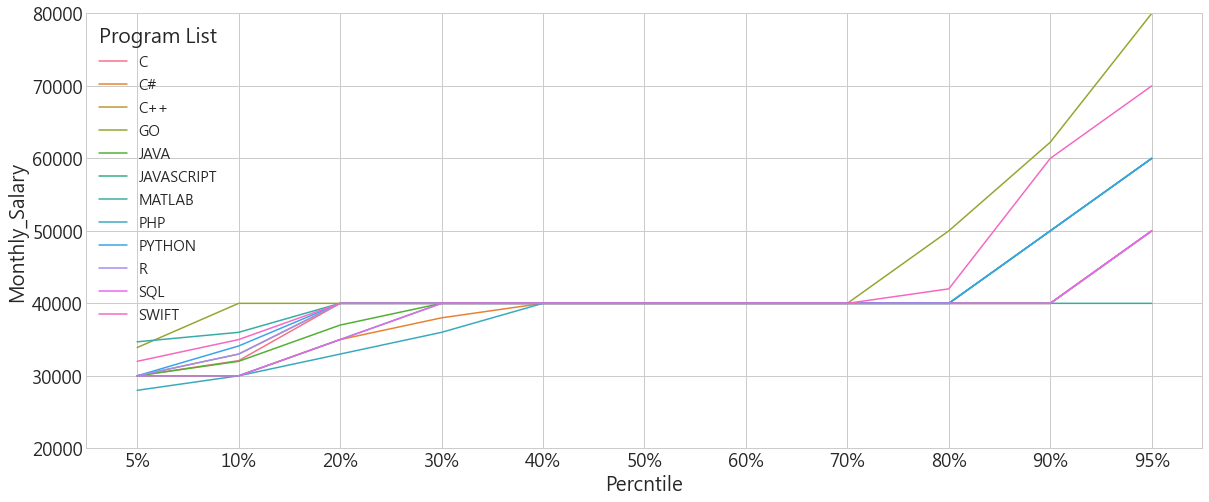

In [58]:
sns.set(font_scale=1.6)
plt.figure(figsize=(20,8))
plt.style.use('seaborn-whitegrid')
sns.lineplot(x='Percntile', y='Monthly_Salary', data=ndf, hue='program_list',)
# plt.legend(loc = 'upper left', bbox_to_anchor = (0,1))
plt.legend(title='Program List', fontsize='14', title_fontsize='20')
plt.ylim(20000,80000)

## 產業、應用與待遇

In [43]:
# df['industry3'].value_counts().head(16)
ndf = df.loc[df['industry3'].apply(lambda x: x in ['電腦軟體服務業', '網際網路相關業', '電腦系統整合服務業', '電腦及其週邊設備製造業', '半導體製造業', '其它軟體及網路相關業', 'IC設計相關業', '光電產業',
                                                   '其他電子零組件相關業', '消費性電子產品製造業', '人力仲介代徵', '工商顧問服務業', '自動控制相關業', '通訊機械器材相關業', '銀行業', '數位內容產業',
                                                   '其他半導體相關業', '多媒體相關業'])].copy()

condlist = [ndf['monthly_salary']<40000,
            ndf['monthly_salary']>=4000]
choicelist = [0,1]
ndf['n_monthly_salary'] = np.select(condlist,choicelist)

ndf = ndf.loc[:,['industry3','program_list','n_monthly_salary']].explode('program_list')
ndf = ndf.loc[ndf['program_list'].apply(lambda x: x in ['C','SQL', 'C++', 'JAVASCRIPT', 'PYTHON', 'JAVA', 'C#', 'PHP','R','GO','MATLAB','SWIFT'])]
ndf

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,industry3,program_list,n_monthly_salary
5,IC設計相關業,C,1
5,IC設計相關業,C++,1
17,電腦系統整合服務業,C#,1
17,電腦系統整合服務業,JAVASCRIPT,1
17,電腦系統整合服務業,SQL,1
...,...,...,...
1256014,人力仲介代徵,JAVA,1
1256015,人力仲介代徵,JAVASCRIPT,1
1256181,電腦軟體服務業,SQL,1
1256245,電腦及其週邊設備製造業,C,1


In [44]:
ndf = ndf.groupby(['industry3', 'program_list'])['n_monthly_salary'].agg(['sum','size'])
ndf = ndf.reset_index()
ndf['rate'] = ndf['sum']/ndf['size']
ndf = ndf.loc[ndf['size']>=30]

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
ndf

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,industry3,program_list,sum,size,rate
0,IC設計相關業,C,676,696,0.971264
1,IC設計相關業,C#,83,102,0.813725
2,IC設計相關業,C++,488,507,0.962525
4,IC設計相關業,JAVA,73,76,0.960526
5,IC設計相關業,JAVASCRIPT,30,32,0.937500
...,...,...,...,...,...
210,電腦軟體服務業,PHP,314,438,0.716895
211,電腦軟體服務業,PYTHON,962,1114,0.863555
212,電腦軟體服務業,R,146,162,0.901235
213,電腦軟體服務業,SQL,1142,1543,0.740117


/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0.5, 0, 'IC設計相關業'),
  Text(1.5, 0, '人力仲介代徵'),
  Text(2.5, 0, '光電產業'),
  Text(3.5, 0, '其他半導體相關業'),
  Text(4.5, 0, '其他電子零組件相關業'),
  Text(5.5, 0, '其它軟體及網路相關業'),
  Text(6.5, 0, '半導體製造業'),
  Text(7.5, 0, '多媒體相關業'),
  Text(8.5, 0, '工商顧問服務業'),
  Text(9.5, 0, '數位內容產業'),
  Text(10.5, 0, '消費性電子產品製造業'),
  Text(11.5, 0, '網際網路相關業'),
  Text(12.5, 0, '自動控制相關業'),
  Text(13.5, 0, '通訊機械器材相關業'),
  Text(14.5, 0, '銀行業'),
  Text(15.5, 0, '電腦及其週邊設備製造業'),
  Text(16.5, 0, '電腦系統整合服務業'),
  Text(17.5, 0, '電腦軟體服務業')])

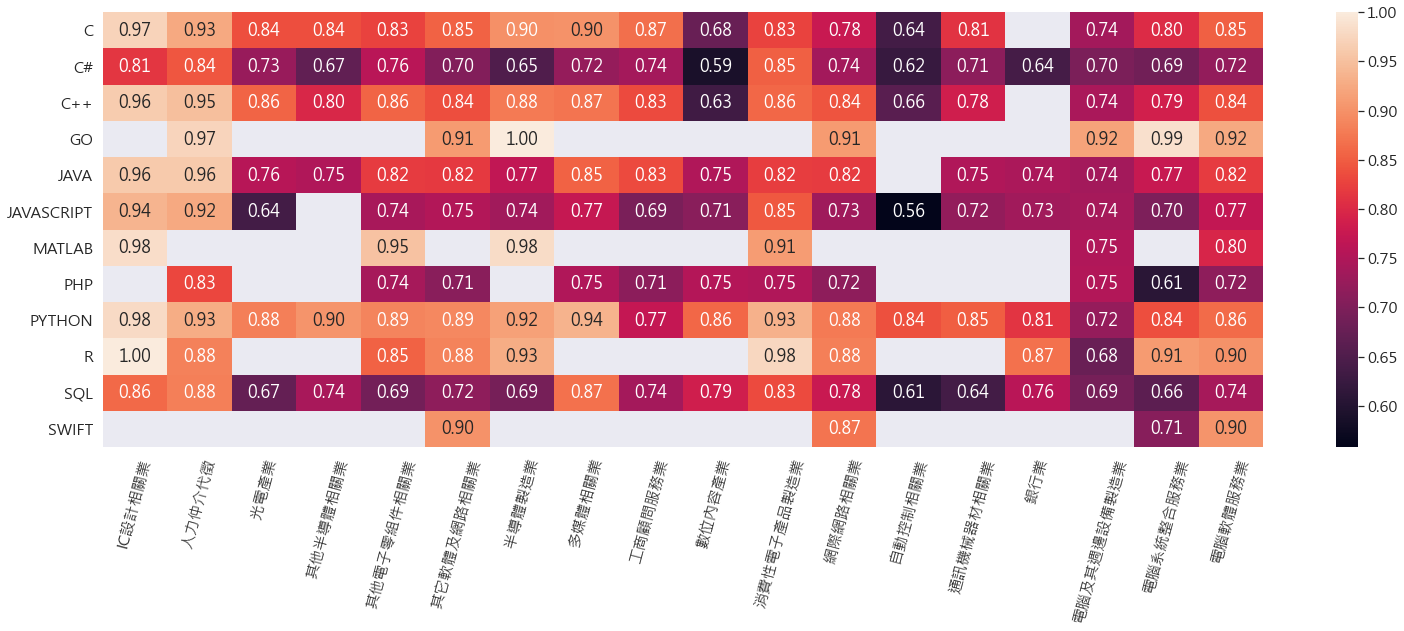

In [49]:
sns.set(font_scale=1.4)
plt.figure(figsize=(26,8))
heat = ndf.pivot('program_list', 'industry3', 'rate')
ax = sns.heatmap(heat,annot=True, fmt='.2f')
ax.set_xlabel('',)
ax.set_ylabel('')
plt.xticks(rotation=75)

# Why Python

## 資料清理

In [72]:
# k = 0
# for jd in df['jobDescription']:
#     if k >= 98:
# #         print(jd)
#         print(jieba.lcut(jd, cut_all=False))
#         print('============')
#     k = k+1
#     if k >= 100:
#         break

In [15]:
words = ['工程師', '客製', '專案', '開發', '系統', '維護', '經驗', '微軟', '資料庫', '撰寫', '顧問','系所','學習',
         '學經歷', '替代役','溝通', '團隊', '製作', '電錶', '測試', '參與', '部門', '詢問', '區塊鏈', '公部門',
         '註解', '日誌', '達到', '實驗', '請勿', '駕照', '應用', '技術','售後', '處理器', '金流', '設計','設計',
         '能力', '參加', '明瞭','架構','請款','目標', '核對', '把關','最後', '服務','負責','踏實','意願','優先', '考慮',
         '業務', '理論', '風險','證券', '資格','軔體','網路','興趣','量產','後端','繪製','防火牆','獨立','雲端','創新',
         '製造','確保','生產', '計畫','多個','透過','確保','熱情','知識','領域','資訊','薪資','大學','研究','研發',
         '產品','良率','控制','提昇','樂於','後台','勇於','對於','熱誠','電腦','組裝', '進行','設計師','對齊','持續',
         '企圖心','馬可夫鏈','正確性','洞見','解決','具備','作業','可靠度','週一', '半導體','密碼學','指導','落實',
         '複雜','統一', '期貨','商務','規劃','追蹤','處理','語言','國外','資策會','加分','異常','維運','洗錢','機械','台中',' 總公司','集團',
         '關係','維繫','佈署','驗證','曇花一現','免費','客戶','同時','屆時','執行', '人員','年假','主動','書審', '通過','證照','從優','機器學習','深度學習','人工智慧', '研發替代役','影像辨識',
         '自然語言處理','供應鏈','正職', '應徵','品質','穩定','瓶頸','坦誠','觀察','市場','確認','總是','辦法','初階', '類比', '基於','分析師','大數據','容器化','市占',
         '製程', '參數', '歡迎', '新鮮人','企業','架構師',
         'google analytics','machine learning', 'deep learning','big data']
for word in words:
    jieba.add_word(word)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.593 seconds.
Prefix dict has been built successfully.


In [16]:
ndf = df.loc[df['program_list'].apply(lambda x: 'PYTHON' in x)]
ndf['program_list'] = 'python'
# ndf = df.loc[:,['jobName','jobDescription','program_list']]
ndf['njobDescription'] = ndf['jobName'] + ndf['jobCategory'] + ' ' + ndf['skill'] + ' ' + ndf['jobDescription']
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: x.lower())

ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('algorithms', 'algorithm', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('applications', 'application', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('customers', 'customer', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('debugging', 'debug', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('experiences', 'experience', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('experienced', 'experience', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('highly', 'high', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('languages', 'language', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('leading', 'lead', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('platforms', 'platform', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('problems', 'problem', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('processes', 'process', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('services', 'service', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('technologies', 'technology', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('tools', 'tool', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('developing', 'develop', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('building', 'build', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('css3', 'css', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('engineers', 'engineer', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('processing', 'process', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('projects', 'project', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('scripting', 'script', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('skills', 'skill', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('solutions', 'solution', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('advanced', 'advance', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('frameworks', 'framework', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('teams', 'team', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('understanding', 'understand', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('requirements', 'requirement', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('systems', 'system', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('working', 'work', x))
ndf['njobDescription'] = ndf['njobDescription'].apply(lambda x: re.sub('products', 'product', x))

ndf['jd_seg'] = ndf['njobDescription'].apply(lambda x: jieba.lcut(x))
ndf['jd_seg'] = ndf['jd_seg'].apply(lambda x: ' '.join(x))
ndf = ndf.drop(['industryNo','industryNo2','industryNo3','program_cnt'],axis=1)
ndf.head(3)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/tlyu0419/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,jobName,custName,specialty,skill,jobDescription,jobCategory,industry3,industry,industry2,monthly_salary,program_list,njobDescription,jd_seg
279,Android軟體工程師,上盈通訊股份有限公司,"Android, Github, C, C++, Java, Python","軟體工程系統開發, 韌體工程開發, 軟體程式設計",歡迎對AI 人工智慧 各方面應用有熱誠的朋友變成Soundwin的AI夥伴\n1. Andr...,"軟體設計工程師, 演算法開發工程師, 電玩程式設計師",通訊機械器材相關業,電子資訊╱軟體╱半導體相關業,電信及通訊相關業,40000.0,python,"android軟體工程師軟體設計工程師, 演算法開發工程師, 電玩程式設計師 軟體工程系統開...","android 軟體 工程師 軟體 設計 工程師 , 演算法 開發 工程師 , 電玩..."
351,資訊專員,裕新汽車股份有限公司,"ASP, C#, Python, Visual Studio, R, DB2, MS SQL...","伺服器網站管理維護, 作業系統基本操作, 資料備份與復原, 電腦設備裝配, 資訊設備操作檢修...",1、公司內部程式修改\n2、使用帳號管理\n3、使用者問題協助\n4、MIS機房及資訊設備管...,"其他資訊專業人員, 網路管理工程師, 系統維護／操作人員",汽車及其零件製造業,一般製造業,運輸工具製造業,40000.0,python,"資訊專員其他資訊專業人員, 網路管理工程師, 系統維護／操作人員 伺服器網站管理維護, 作業...","資訊 專員 其他 資訊 專業 人員 , 網路 管理 工程師 , 系統 維護 ／ 操作..."
1184,【車用系統部】軟體工程師/ 高級工程師,昇銳電子股份有限公司,,,1.車隊管理 VMS系統開發/ 規劃\n2.車隊管理 系統之分析、設計以及程式撰寫\n3.影...,軟體設計工程師,光學器材製造業,電子資訊╱軟體╱半導體相關業,光電及光學相關業,40000.0,python,【車用系統部】軟體工程師/ 高級工程師軟體設計工程師 1.車隊管理 vms系統開發/ 規劃...,【 車用 系統 部 】 軟體 工程師 / 高級 工程師 軟體 設計 工程師 1 ...


In [17]:
vectorizer = CountVectorizer(min_df=10,
                             max_features=300,
                             stop_words=['10','11','able','an','and','are','at', 'be', 'by', 'com','ensure', 'etc','for', 'from', 'can', 'cd', 'best', 'as', 'about',
                                        'all', 'bachelor','good','hands','have','http', 'https','in', 'is','it','job','lead','internal','looking','like','level', 'any',
                                         'closely','more','must','new','of', 'on', 'one', 'open', 'or', 'other', 'our','plus', 'strong','such','who','what','we', 'if',
                                         'least','that','the', 'this','to','tool','up','well','will','with', 'work', 'written', 'www', 'you', 'your', 'key', 'tw','basic',
                                         'high', 'using', '使用','一個', '品質','思考','文件','概念','歡迎', 
                                         '一種', '一起', '下列', '不同', '主動', '主管', '主要', '了解', '事項', '交辦', '人員', '人才', '以上', '以下', '以及', '任一',
                                         '任務', '企業', '作品', '例如', '優先', '內容', '內部', '公司', '共同', '其他', '具備', '具有', '出差', '分享' , '一年',
                                         '三年','加入','加分', '包含', '包括','協助','參與', '可以', '台北', '台灣', '各種', '各項','喜歡', '單位', '團隊', '地點', '執行',
                                         '夥伴','如果','完成', '完整','對於','尤佳', '履歷', '工作','確保', '福利', '為佳', '熟悉', '熟練', '熱忱', '熱情', '根據', '樂於',
                                         '並且','tw','希望','必備','必要','問題', '基本', '基礎','希望','面試','願意','我們',
                                         'experience', '經驗'
                                        ]
                            )
data_vectorized  = vectorizer.fit_transform(ndf['jd_seg'])
pd.DataFrame(data=data_vectorized.toarray(),
             columns=vectorizer.get_feature_names(),
             index=ndf['jobName'])

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ability,ai,algorithm,analysis,analytics,android,api,app,application,architecture,...,雲端,電子,電腦,電路,需求,需要,韌體,項目,領域,驗證
jobName,,,,,,,,,,,,,,,,,,,,,
Android軟體工程師,0,3,0,0,0,3,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
資訊專員,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
【車用系統部】軟體工程師/ 高級工程師,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
軟體工程師,0,0,0,0,0,1,0,0,0,0,...,0,2,2,0,0,0,2,0,0,0
遊戲機率設計工程師,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Backend Engineer 後端工程師,0,0,0,0,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
★★★正職代招★★★ Web前端工程師_數據分析,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
資深JAVA開發工程師,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## LDA
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Grid Search

In [20]:
n_topics = []
Likelihood = []
Perplexity = []

for n in range(1,21):
    lda_model  = LatentDirichletAllocation(n_components=n,
                                           max_iter=300,
                                           learning_method='batch',
                                           n_jobs=8,
                                           random_state=42)
    lda_model.fit(data_vectorized)
    n_topics.append(n)
    Likelihood.append(lda_model.score(data_vectorized))
    Perplexity.append(lda_model.perplexity(data_vectorized))

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
n_comps = pd.DataFrame(data=[n_topics,Likelihood, Perplexity]).T
n_comps.columns=['n_topics','Likelihood','Perplexity']
n_comps

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,n_topics,Likelihood,Perplexity
0,1.0,-2.093572e+06,185.717233
1,2.0,-1.965049e+06,134.762396
2,3.0,-1.945928e+06,128.483398
3,4.0,-1.927973e+06,122.853780
4,5.0,-1.927234e+06,122.627589
5,6.0,-1.913038e+06,118.359755
6,7.0,-1.908399e+06,116.997470
7,8.0,-1.899797e+06,114.512871
8,9.0,-1.896616e+06,113.607539
9,10.0,-1.891278e+06,112.104147


/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='n_topics', ylabel='Perplexity'>

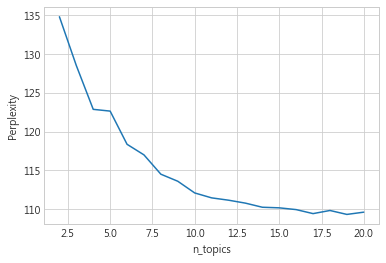

In [22]:
sns.lineplot(x='n_topics',y='Perplexity',data=n_comps.loc[n_comps['n_topics']!=1.0])
# sns.lineplot(x='n_topics',y='Likelihood',data=n_comps)

In [23]:
n_topics = 8
lda_model  = LatentDirichletAllocation(n_components=n_topics,
                                       max_iter=500,
                                       learning_method='batch',
                                       n_jobs=8,
                                       random_state=42)
lda_model.fit(data_vectorized)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(max_iter=500, n_components=8, n_jobs=8,
                          random_state=42)

In [24]:
lda_model.score(data_vectorized)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-1899797.2223137068

In [25]:
lda_model.perplexity(data_vectorized)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


114.51287124034704

### LDA result

In [26]:
df_document_topic  = pd.DataFrame(data=lda_model.transform(data_vectorized),
                                  columns=["Topic" + str(i) for i in range(lda_model.n_components)])
df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
ndf['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
df_document_topic

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
0,0.247163,0.003051,0.003053,0.003050,0.003053,0.003050,0.734531,0.003050,6
1,0.001546,0.825010,0.001545,0.001544,0.001545,0.001544,0.165723,0.001543,1
2,0.981362,0.002666,0.002665,0.002660,0.002662,0.002660,0.002664,0.002660,0
3,0.171424,0.101529,0.001346,0.001349,0.042763,0.001347,0.678894,0.001349,6
4,0.294663,0.002200,0.692165,0.002193,0.002196,0.002193,0.002196,0.002193,2
...,...,...,...,...,...,...,...,...,...
6195,0.947406,0.002123,0.002121,0.002122,0.039864,0.002120,0.002121,0.002123,0
6196,0.645320,0.002121,0.341958,0.002120,0.002121,0.002119,0.002122,0.002119,0
6197,0.002198,0.002194,0.002196,0.825391,0.002194,0.002197,0.037271,0.126359,3
6198,0.772456,0.175449,0.002122,0.002122,0.041488,0.002120,0.002121,0.002123,0


In [27]:
topic_percent = df_document_topic['dominant_topic'].value_counts().reset_index()
topic_percent['percent'] = topic_percent['dominant_topic']/6200
topic_percent

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,dominant_topic,percent
0,0,1261,0.203387
1,6,1169,0.188548
2,2,988,0.159355
3,7,876,0.141290
4,1,629,0.101452
5,3,542,0.087419
6,5,388,0.062581
7,4,347,0.055968


/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


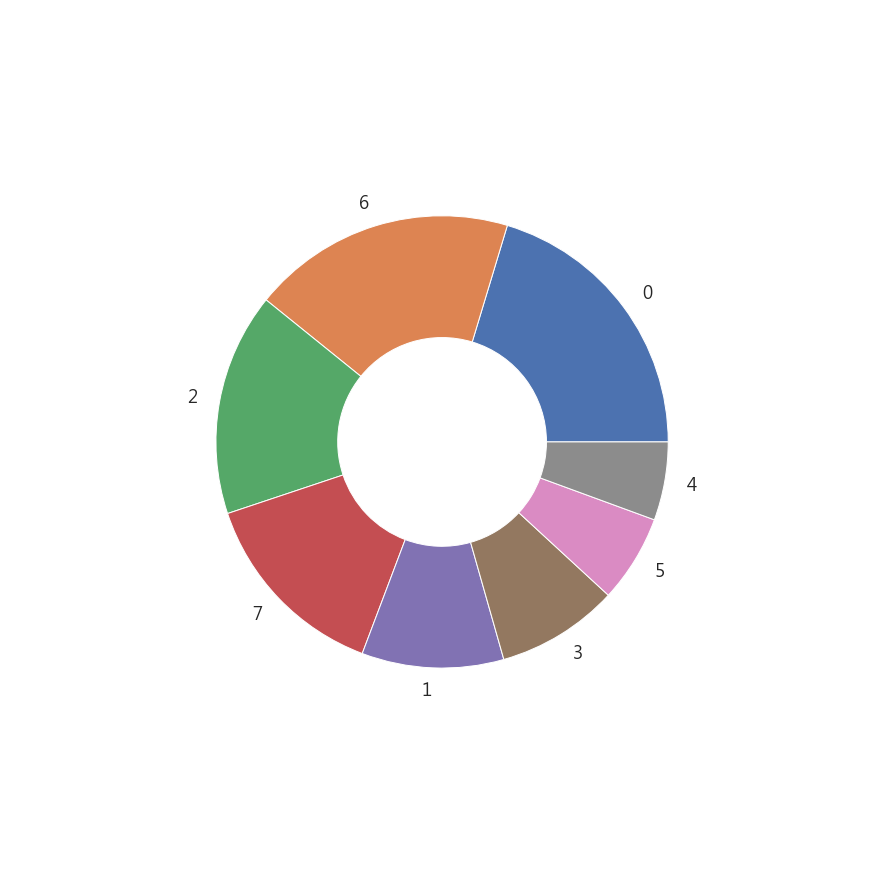

In [59]:
plt.figure(figsize=(16,16))
# fig, ax = plt.subplots()
size = 0.35
plt.pie(topic_percent['percent'], labels=topic_percent['index'],
       radius=1-size,
       wedgeprops=dict(width=size, edgecolor='w'))
# plt.title('Population')
plt.show()

In [29]:
df_topic_keywords = pd.DataFrame(lda_model.components_,
                                 columns=vectorizer.get_feature_names())
df_topic_keywords = df_topic_keywords.reset_index().rename(columns={'index':'Topic'})
df_topic_keywords

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,ability,ai,algorithm,analysis,analytics,android,api,app,application,...,雲端,電子,電腦,電路,需求,需要,韌體,項目,領域,驗證
0,0,0.125021,43.276684,0.125035,0.125033,0.125138,51.947069,1163.651444,338.318237,0.125105,...,349.745439,79.855207,0.125207,0.125007,541.941558,242.266652,0.125052,264.113817,53.550228,0.125149
1,1,0.125027,0.125127,0.125016,0.125066,0.125082,0.125169,0.125130,0.125202,0.125131,...,779.034385,0.125225,196.296900,0.125005,205.952329,43.689751,0.125032,75.680863,78.459988,28.546773
2,2,0.125034,523.252772,0.125044,0.125139,59.151718,0.125065,0.125160,44.758733,0.125087,...,60.468947,51.093487,75.997420,0.125026,795.313794,195.441767,0.125030,112.372088,428.515307,99.438942
3,3,194.311296,0.125150,0.125193,53.622236,7.418883,97.468209,274.675718,95.465832,841.296319,...,8.250790,0.125074,0.125214,0.125001,0.125041,0.125040,0.125171,0.125093,0.125122,0.125022
4,4,0.125033,0.125065,0.125057,0.125090,0.125016,167.567497,50.047221,185.720472,0.125116,...,0.125137,14.744862,8.793802,0.125069,227.279049,76.101399,0.125210,148.149248,9.705716,271.608377
5,5,258.307836,650.544055,570.227473,525.463031,332.804083,0.125119,0.125108,15.940619,151.470836,...,0.125082,0.125103,0.125176,0.125019,0.125037,0.125065,0.125135,0.125052,0.125052,0.125021
6,6,0.125020,705.426011,0.125117,0.125093,0.125022,180.205052,0.125107,0.125200,0.125111,...,0.125185,629.855464,312.411188,360.124453,100.138118,0.125271,1120.519354,89.308802,136.393522,505.905442
7,7,533.755734,0.125136,137.022066,520.289312,0.125058,148.436820,0.125112,2.545705,543.607295,...,0.125034,105.075579,0.125095,0.125421,0.125074,0.125054,236.730017,0.125037,0.125065,0.125274


In [30]:
df_topic_keywords = df_topic_keywords.melt(id_vars='Topic',var_name='Keywords')
df_topic_keywords = df_topic_keywords.sort_values(['Topic','value'],ascending=[True, False])
df_topic_keywords.groupby('Topic').head(7)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Keywords,value
2312,0,開發,5900.177976
1896,0,程式,4987.866940
2120,0,設計,4941.212327
2208,0,軟體,3893.720498
1440,0,工程師,2794.704585
1928,0,系統,2723.520729
2176,0,資料庫,1766.524736
1929,1,系統,4465.095459
1913,1,管理,2991.800768
1945,1,維護,2063.296319


In [31]:
# pyLDAvis.enable_notebook()
# panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne') # mmds, tsne
# panel

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## docvector

# WordCloud

In [32]:
df_topic_keywords

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Keywords,value
2312,0,開發,5900.177976
1896,0,程式,4987.866940
2120,0,設計,4941.212327
2208,0,軟體,3893.720498
1440,0,工程師,2794.704585
...,...,...,...
1647,7,數據,0.125007
1239,7,串接,0.125005
1359,7,大數據,0.125005
2271,7,運維,0.125002


/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7


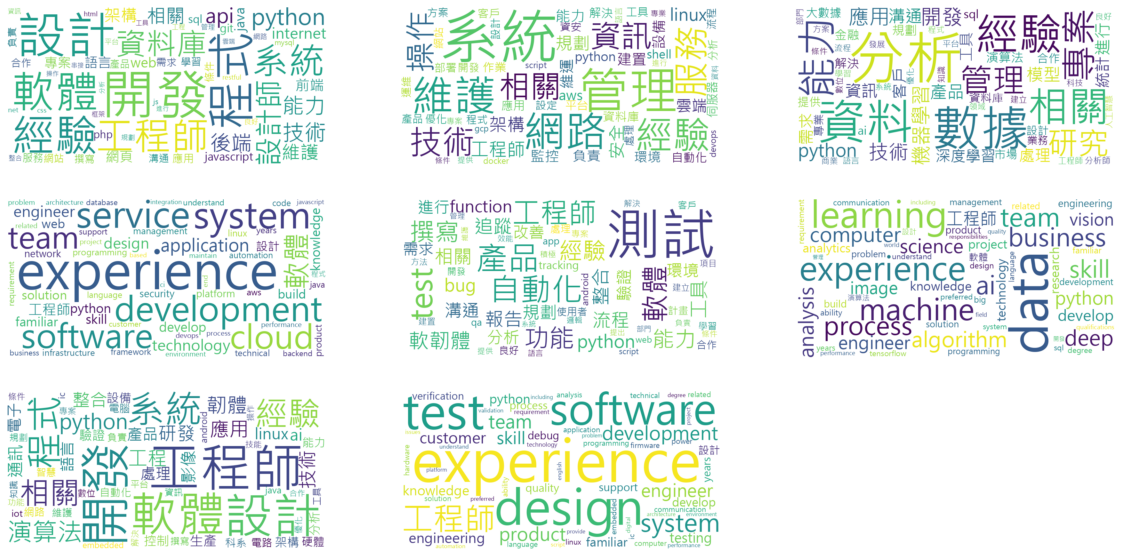

In [445]:
topics = lda_model.n_components
leng = 3

plt.figure(figsize=(20, 10))

for topic in df_topic_keywords['Topic'].unique():
    print(topic)
    wocld = df_topic_keywords.loc[df_topic_keywords['Topic']==topic]
    wocld = wocld.head(60)
    
    # plot wordcloud
    d = {}
    for k, v in zip(wocld['Keywords'], wocld['value']):
        d[k] = int(v)
    
    plt.subplot(3, leng, topic+1)
    wordcloud = WordCloud(font_path='/mnt/c/Windows/Fonts/msjh.ttc',
                          width=1000,
                          height=500,
                          background_color="white").generate_from_frequencies(d)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
plt.show()

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7


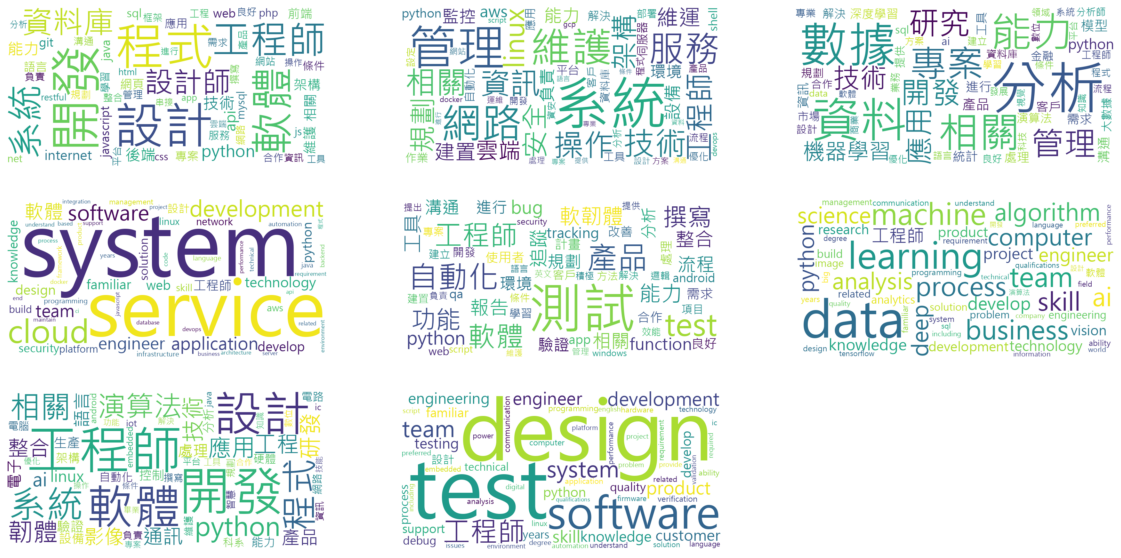

In [33]:
topics = lda_model.n_components
leng = 3

plt.figure(figsize=(20, 10))

for topic in df_topic_keywords['Topic'].unique():
    print(topic)
    wocld = df_topic_keywords.loc[df_topic_keywords['Topic']==topic]
    wocld = wocld.head(60)
    
    # plot wordcloud
    d = {}
    for k, v in zip(wocld['Keywords'], wocld['value']):
        d[k] = int(v)
    
    plt.subplot(3, leng, topic+1)
    wordcloud = WordCloud(font_path='/mnt/c/Windows/Fonts/msjh.ttc',
                          width=1000,
                          height=500,
                          background_color="white").generate_from_frequencies(d)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
plt.show()

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,jobName,custName,specialty,skill,jobDescription,jobCategory,industry3,industry,industry2,monthly_salary,program_list,njobDescription,jd_seg,dominant_topic
1458,遊戲機率設計工程師,尊博科技股份有限公司,"C++, Python, R, Excel, Outlook, PowerPoint, Word",,**應徵時請附上Cover Letter(自薦信)**\n\n1.遊戲設計\n 設定遊...,"電玩程式設計師, 統計精算人員, 數學研究員",電腦軟體服務業,電子資訊╱軟體╱半導體相關業,軟體及網路相關業,32000.0,python,"遊戲機率設計工程師電玩程式設計師, 統計精算人員, 數學研究員 **應徵時請附上cover...","遊戲 機率 設計 工程師 電玩 程式 設計師 , 統計 精算 人員 , 數學 研究 ...",8
2045,軟體自動化測試工程師(新竹),全景軟體股份有限公司,,,1.建立測試環境，各項產品運作架構熟悉\n2.負責系統自動化測試系統及相關系統操作(Jenk...,"軟體設計工程師, Internet程式設計師",電腦軟體服務業,電子資訊╱軟體╱半導體相關業,軟體及網路相關業,35000.0,python,"軟體自動化測試工程師(新竹)軟體設計工程師, internet程式設計師 1.建立測試環境...","軟體 自動化 測試 工程師 ( 新竹 ) 軟體 設計 工程師 , internet 程式...",8
2154,Software Engineer in Test,基點資訊股份有限公司,"Linux, Shell, Python, ssh",,The job will be responsible for test automatio...,"軟體設計工程師, 軟韌體測試工程師",網際網路相關業,電子資訊╱軟體╱半導體相關業,軟體及網路相關業,38000.0,python,"software engineer in test軟體設計工程師, 軟韌體測試工程師 th...","software engineer in test 軟體 設計 工程師 , ...",8
2155,AI數據分析與演算法開發工程師 (外縣市提供宿舍),竑騰科技股份有限公司,"C#, C++, Python, Visual C#, Visual C++","軟體工程系統開發, 軟體程式設計, Machine Learning","**因新冠肺炎疫情影響，前來廠區面試請務必配戴口罩，謝謝! **\n\n1. C++,C#,...","軟體設計工程師, 光電工程師, 電子工程師",半導體製造業,電子資訊╱軟體╱半導體相關業,半導體業,35000.0,python,"ai數據分析與演算法開發工程師 (外縣市提供宿舍)軟體設計工程師, 光電工程師, 電子工程...",ai 數據 分析 與 演算法 開發 工程師 ( 外縣 市 提供 宿舍 ) 軟體 設計...,8
2351,【金融科技】JAVA 程式設計師(新人/研發替代役),玉山銀行_玉山商業銀行股份有限公司,"Android, Github, Git, ASP.NET, C#, C++, COBOL,...","系統架構規劃, 軟體工程系統開發, 軟體程式設計, 網路程式設計, 資料庫系統管理維護, 資...",1. 協助組織內各資訊系統之程式開發、單元測試撰寫、功能測試\n2. 協助資料庫程式開發與維...,"軟體設計工程師, Internet程式設計師, 系統分析師",銀行業,金融投顧及保險業,金融機構及其相關業,39000.0,python,"【金融科技】java 程式設計師(新人/研發替代役)軟體設計工程師, internet程式設...",【 金融 科技 】 java 程式 設計師 ( 新人 / 研發替代役 ) 軟體 設計 工...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252790,【營運】存匯作業管理人員,國泰世華商業銀行股份有限公司_人力資源部,"Excel, PowerPoint, Word",,1.存匯作業流程設計、精實及相關規章之修訂 \n2.系統需求規格書撰寫及測試 \n3.分行櫃...,其他專案管理師,銀行業,金融投顧及保險業,金融機構及其相關業,30000.0,python,【營運】存匯作業管理人員其他專案管理師 1.存匯作業流程設計、精實及相關規章之修訂 \n2...,【 營運 】 存匯 作業 管理 人員 其他 專案 管理 師 1 . 存匯 作業 流程...,8
1253006,數據分析工程師,久元電子股份有限公司,"C#, C++, Java, Python, Ruby, Visual Basic .net",,1. 資料倉儲管理與數據中心建置、數據資料清洗與統計分析。 \n2. 運用演算法依據數據處理...,"軟體設計工程師, 半導體工程師",半導體製造業,電子資訊╱軟體╱半導體相關業,半導體業,36000.0,python,"數據分析工程師軟體設計工程師, 半導體工程師 1. 資料倉儲管理與數據中心建置、數據資料清...","數據 分析 工程師 軟體 設計 工程師 , 半導體 工程師 1 . 資料 倉...",8
1253127,助理工程師（人工智慧）,摯陞數位科技有限公司,"Java, JSP, R",,【關於此職務】 \n如果您對系統開發很有興趣，嚮往以系統開發為終身志業，歡迎您來應徵這個職務...,"軟體設計工程師, 通訊軟體工程師, 自動控制工程師",網際網路相關業,電子資訊╱軟體╱半導體相關業,軟體及網路相關業,24000.0,python,"助理工程師（人工智慧）軟體設計工程師, 通訊軟體工程師, 自動控制工程師 【關於此職務】 ...","助理 工程師 （ 人工智慧 ） 軟體 設計 工程師 , 通訊 軟體 工程師 , 自動...",0
1253237,IE工程師/擴建規劃管理,南亞科技股份有限公司,"Python, Tableau","專案時間╱進度控管, 專案規劃執行╱範圍管理, 專案溝通╱整合管理, 專案管理架構及專案說明...","1.專案進度控管, \n2.專案規劃與執行,\n3.專案溝通協調,\n4.預算控管,\n5....",工業工程師／生產線規劃,半導體製造業,電子資訊╱軟體╱半導體相關業,半導體業,31000.0,python,"ie工程師/擴建規劃管理工業工程師／生產線規劃 專案時間╱進度控管, 專案規劃執行╱範圍管理...",ie 工程師 / 擴建 規劃 管理 工業 工程師 ／ 生產 線 規劃 專案 時間 ╱ 進...,8


## 職務分群 by docvector
- 職務可以分成幾類、各個程式語言的百分比又是怎麼樣?
- 也許不應該用百分比，而是看各個類型的職務中，Python是不是都有出現

In [ ]:
# !python3 -m spacy download zh_core_web_lg
# nlp = spacy.load('zh_core_web_lg') # zh_core_web_md zh_core_web_lg zh_core_web_sm
# proper_nouns = program_list['Languages']
# nlp.tokenizer.pkuseg_update_user_dict(proper_nouns)

In [46]:
# nlp = spacy.load('zh_core_web_sm') # zh_core_web_md zh_core_web_lg
# # proper_nouns = program_list['Languages']
# # nlp.tokenizer.pkuseg_update_user_dict(proper_nouns)

In [429]:
# df['jd_vector'] = df['jobName'] + ' ' + df['jobDescription']
# df['jd_vector'] = df['jd_vector'].apply(lambda x: nlp(x).vector)
# df.head(3)

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [430]:
# # Cluster
# from nltk.cluster import KMeansClusterer
# import nltk
# km = KMeansClusterer(num_means=10, distance=nltk.cluster.util.euclidean_distance, repeats=30)
# df['cluster'] = km.cluster(vectors=df['jd_vector'], assign_clusters=True)
# df

/home/tlyu0419/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 分析2: 為什麼是Python
- Python 的職務類型與介紹

# 給新鮮人的建議
1. 怎麼選職務?